In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.datasets import make_spd_matrix
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.kernel_ridge import KernelRidge

<h3>Generate Random but Correlated data </h3>
<p>Using randomly generated covariance matrics, this function generates correlated data</p>
<p>Noise is added to simulate real-world data</p>
<p>Data is scaled though this is not strictly necessary</p>

In [3]:
def mergeJoin(data, id='x'):
    """ Helper function to outer join many dataframes
        Inspired by merge sort
        @param data: List of dataframes
        @retval: single wide dataframe
    """
    if len(data) > 1:
        mid = len(data) // 2
        left = data[:mid]
        right = data[mid:]

        # Recursive call on each half
        return mergeJoin(left, id).merge(mergeJoin(right, id), on=id, how='outer').dropna()

    if len(data) == 1:
        return data[0]

In [4]:
size = 100000
results = []
for i in tqdm(range(0, 10)):
    # generate random covariance matrices
    l = np.random.randint(2, 20)
    mean = np.random.rand(l)
    cov = make_spd_matrix(l, random_state=0)
    # for debugging, generates a covariance matrix of 1s
#     cov = np.ones((l, l))

    # generates random/correlated data based on given mean/covairance matrix
    pts = np.random.multivariate_normal(mean, cov, size=size)
    x, y = pts[:, 0], pts[:, 1]
    # add Gaussian noise
    y = y + np.random.normal(0, 1, size)
    # scale
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x.reshape(-1, 1)).T[0]
    # round
    x = np.around(x, 5)
    # plot
#     plt.plot(x, y, '.')
#     plt.xlim(-1, 2)
#     plt.grid()
#     plt.show()
    
    t_df = pd.DataFrame(list(zip(x, y)), columns=['x', 'y' + str(i)])
    t_df.drop_duplicates('x', inplace=True)
    results.append(t_df)

100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


<h3>Merging</h3>
<p>This is to merge multiple columns together to simulate cases where multiple columns correlate with the response</p>

In [5]:
df = mergeJoin(results)
df.sort_values('x', inplace=True)
# re-scaling to balance out x
df = df[(df['x'] != 0) & (df['x'] != 1)]
scaler = MinMaxScaler()
df['x'] = scaler.fit_transform(df['x'].values.reshape(-1, 1)).T[0]
df

x        y0        y1        y2        y3        y4        y5  \
1082   0.000000  1.151247  0.461406  0.626917  0.232233  0.070572  2.259797   
167    0.014858 -1.502873 -0.302568  1.562856  0.469204  2.890821  2.069441   
20085  0.023328 -2.834849  1.359193 -0.113111  2.801832  1.539562  3.236011   
20273  0.045891 -0.053755  0.171740  1.344894 -0.296334  1.467950  3.185909   
15416  0.047183  0.738459  0.690577 -1.984744 -2.008388  1.804325  2.389912   
...         ...       ...       ...       ...       ...       ...       ...   
8831   0.936978 -2.916548 -0.003836  1.796676  1.239187  1.730624 -0.427496   
19946  0.938103  1.119912  1.682459  0.173659  1.406987  1.793064 -0.323260   
8393   0.952482 -0.650818 -0.947033  1.693132  4.056492  0.659465 -2.105065   
9177   0.959780 -0.224982 -0.521947  1.034654  1.522508  2.309685 -1.105758   
20570  1.000000  0.555033  0.728874 -1.266276  1.747371  1.659784 -2.288260   

             y6        y7        y8        y9  
1082  -1.527428  2.055362  1.194170  4.496773  
167    0.913439  1.121925 -0.952912  2.358743  
20085  0.880729  1.718247 -2.142655  5.713720  
20273  0.264837  1.782452  1.740350 -0.005475  
15416  1.040559  2.390833  1.390693  5.694267  
...         ...       ...       ...       ...  
8831  -3.078243 -0.769838  0.927146  0.602131  
19946  0.624191 -2.273947  1.592449 -2.985799  
8393   0.594206 -0.452118  0.611942 -0.452215  
9177  -2.388758 -2.315641 -1.446627 -3.625513  
20570  1.359163 -1.065305 -1.641568 -2.968321  

[14460 rows x 11 columns]

<h3>Generate Random Bi-modal Data</h3>
<p>Generate 2 sets of normally distributed data</p>
<p>Concat, and join with original (sorted) dataset</p>

In [6]:
for i in range(0, 2):
    last_col_index = int(df.columns[-1].split('y')[1])
    N = df.shape[0]
    mu, sigma = np.random.randint(40, 100), np.random.randint(1, 5)
    mu2, sigma2 = int(mu % 5) + np.random.randint(1, 5), sigma**2 + 10
    bm1 = np.random.normal(mu, sigma, N)
    bm2 = np.random.normal(mu2, sigma2, N)
    bm = np.concatenate([bm1, bm2])
    bm[::2]
    # this may throw an error?
    df['y' + str(last_col_index + 1)] = bm[::2]
    # plt.hist(bm[::2])

<h3>Generate Random Data</h3>
<p>Generate 100 sets of normally distributed data</p>

In [7]:
for i in range(0, 100):
    x = df['x'].values
    y = x + np.random.normal(0.5, 3, len(x))
    y = y - np.random.normal(-1, 20, len(x))**3

    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1)).T[0]
#     plt.plot(x, y, '.')
#     plt.xlim(-1, 2)
#     plt.grid()
#     plt.show()
    last_col_index = int(df.columns[-1].split('y')[1])
    df['y' + str(last_col_index + 1)] = y

C:\Users\TanDe\AppData\Local\Temp/ipykernel_25972/2072591345.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['y' + str(last_col_index + 1)] = y
C:\Users\TanDe\AppData\Local\Temp/ipykernel_25972/2072591345.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['y' + str(last_col_index + 1)] = y
C:\Users\TanDe\AppData\Local\Temp/ipykernel_25972/2072591345.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [8]:
df.describe()

x            y0            y1            y2            y3  \
count  14460.000000  14460.000000  14460.000000  14460.000000  14460.000000   
mean       0.491806      0.459585      0.368634      0.265982      0.254844   
std        0.163376      2.091475      1.153090      1.192658      1.389779   
min        0.000000     -6.964624     -3.988949     -4.467215     -4.763083   
25%        0.369297     -0.935414     -0.401399     -0.546466     -0.692550   
50%        0.491793      0.470670      0.361378      0.267428      0.246824   
75%        0.612424      1.848492      1.137492      1.067486      1.182517   
max        1.000000      9.519105      5.201083      4.632769      7.093658   

                 y4            y5            y6            y7            y8  \
count  14460.000000  14460.000000  14460.000000  14460.000000  14460.000000   
mean       0.938744      0.861316      0.855936      0.035702      0.558370   
std        1.581900      1.370450      1.249907      1.381149      1.276136   
min       -5.193985     -4.548759     -3.849228     -5.814923     -4.454207   
25%       -0.112160     -0.090425      0.001793     -0.914174     -0.293533   
50%        0.924591      0.855003      0.859150      0.037906      0.572464   
75%        2.007469      1.806243      1.699669      0.990150      1.418558   
max        7.469391      6.036179      5.663874      5.139591      5.177140   

       ...          y102          y103          y104          y105  \
count  ...  14460.000000  14460.000000  14460.000000  14460.000000   
mean   ...      0.488675      0.474111      0.530370      0.501114   
std    ...      0.029815      0.025886      0.038575      0.019563   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.485842      0.471167      0.526882      0.499000   
50%    ...      0.487798      0.472681      0.529330      0.500187   
75%    ...      0.490572      0.475228      0.533028      0.502097   
max    ...      1.000000      1.000000      1.000000      1.000000   

               y106          y107          y108          y109          y110  \
count  14460.000000  14460.000000  14460.000000  14460.000000  14460.000000   
mean       0.436845      0.519244      0.588374      0.506344      0.454906   
std        0.037516      0.033298      0.033145      0.034304      0.035370   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.432578      0.516120      0.585248      0.502815      0.450928   
50%        0.435014      0.518163      0.587176      0.505029      0.453143   
75%        0.438837      0.521368      0.590663      0.508561      0.456699   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               y111  
count  14460.000000  
mean       0.496736  
std        0.030362  
min        0.000000  
25%        0.493626  
50%        0.495411  
75%        0.498450  
max        1.000000  

[8 rows x 113 columns]

<h3>EDA</h3>



In [9]:
col_names=df.columns
col_names

Index(['x', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8',
       ...
       'y102', 'y103', 'y104', 'y105', 'y106', 'y107', 'y108', 'y109', 'y110',
       'y111'],
      dtype='object', length=113)

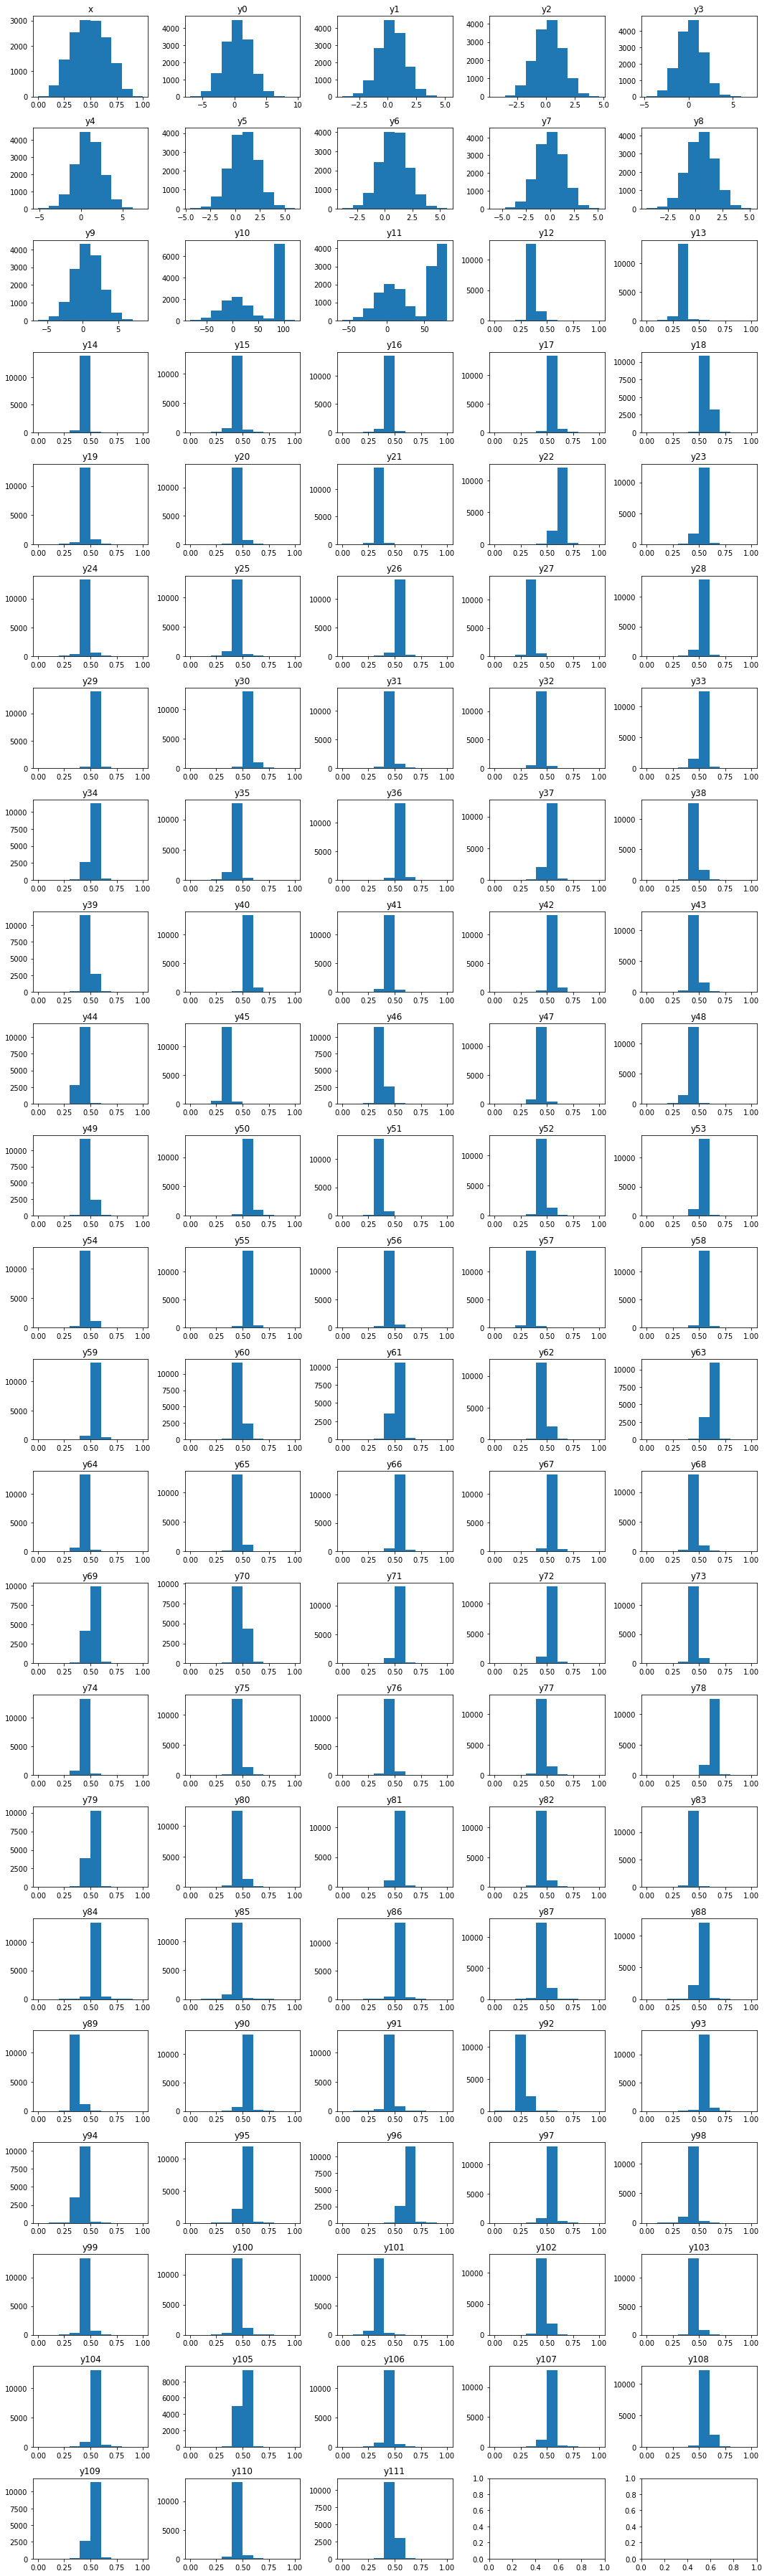

In [14]:
#histogram of all parts
#row by col
fig,axs=plt.subplots(23,5,figsize=(15,50))
c=0
for i in range(0,23):
    for j in range(0,5):
        if c >= 113:
            break
        axs[i,j].set_title(str(col_names[c]))
        axs[i,j].hist(df.iloc[:,c])
        c=c+1
        

#plt.hist(df.iloc[:,50])
fig.tight_layout()
plt.show()

x        y0        y1        y2        y3        y4        y5  \
x     1.000000  0.034264  0.002826  0.144884  0.197680 -0.134070 -0.452506   
y0    0.034264  1.000000  0.000273  0.010910 -0.000626  0.003199 -0.005964   
y1    0.002826  0.000273  1.000000 -0.007965  0.003925 -0.000124 -0.002327   
y2    0.144884  0.010910 -0.007965  1.000000  0.032604 -0.028722 -0.069711   
y3    0.197680 -0.000626  0.003925  0.032604  1.000000 -0.026027 -0.091643   
...        ...       ...       ...       ...       ...       ...       ...   
y107 -0.001233  0.005698  0.006876 -0.006745  0.016916  0.001931 -0.005686   
y108 -0.000777 -0.019084 -0.003324 -0.009267  0.020297  0.001627 -0.012123   
y109 -0.010428  0.002452  0.013741 -0.009049 -0.005195  0.002451  0.003931   
y110  0.012812  0.010452 -0.001484 -0.010877 -0.003836 -0.017418 -0.010361   
y111 -0.001013  0.004763 -0.002128  0.019043 -0.003565  0.003475 -0.006371   

            y6        y7        y8  ...      y102      y103      y104  \
x     0.000273 -0.444015 -0.140729  ... -0.000818 -0.008475 -0.006335   
y0   -0.004264 -0.009091  0.010387  ...  0.000958 -0.003896 -0.007784   
y1   -0.014189 -0.017839 -0.002816  ...  0.003131 -0.006803 -0.003962   
y2   -0.012347 -0.057740 -0.015388  ...  0.006841 -0.008981 -0.014422   
y3   -0.005886 -0.096258 -0.024572  ... -0.004567  0.008185 -0.003335   
...        ...       ...       ...  ...       ...       ...       ...   
y107 -0.006657  0.004019  0.012659  ... -0.005651 -0.018320 -0.013773   
y108  0.008482  0.004661 -0.003293  ...  0.009343 -0.001137  0.009301   
y109 -0.006491 -0.010653 -0.007757  ...  0.002826  0.007415 -0.001897   
y110  0.010576 -0.008424 -0.001108  ...  0.004170  0.005157 -0.006074   
y111  0.006814 -0.002361  0.006012  ... -0.000727 -0.006953 -0.000016   

          y105      y106      y107      y108      y109      y110      y111  
x    -0.005080 -0.011861 -0.001233 -0.000777 -0.010428  0.012812 -0.001013  
y0    0.010649 -0.004911  0.005698 -0.019084  0.002452  0.010452  0.004763  
y1    0.007077 -0.006503  0.006876 -0.003324  0.013741 -0.001484 -0.002128  
y2   -0.007267 -0.017792 -0.006745 -0.009267 -0.009049 -0.010877  0.019043  
y3    0.009307  0.009370  0.016916  0.020297 -0.005195 -0.003836 -0.003565  
...        ...       ...       ...       ...       ...       ...       ...  
y107 -0.023522 -0.011109  1.000000 -0.008036 -0.005124  0.016624  0.004377  
y108 -0.006683  0.007454 -0.008036  1.000000  0.000401 -0.000848 -0.011662  
y109 -0.009897 -0.015043 -0.005124  0.000401  1.000000  0.003177  0.012990  
y110 -0.011223 -0.002656  0.016624 -0.000848  0.003177  1.000000 -0.000373  
y111 -0.009145  0.008507  0.004377 -0.011662  0.012990 -0.000373  1.000000  

[113 rows x 113 columns]

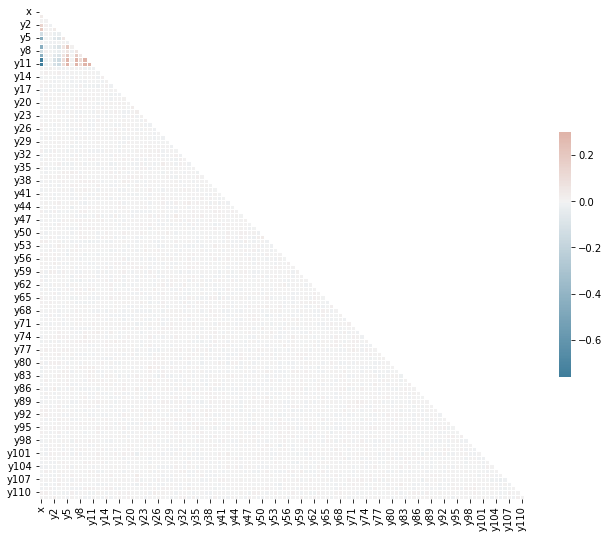

In [16]:
# Compute the correlation matrix
corr_heatmap=df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_heatmap, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_heatmap, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


corr_heatmap

<AxesSubplot:>

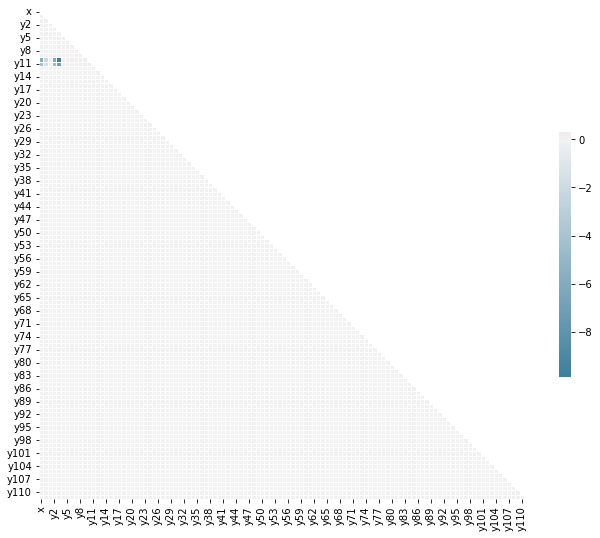

In [15]:
# Compute the correlation matrix
corr_heatmap=df.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_heatmap, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_heatmap, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


max variance:  0.05896479777765006
max covariance:  0.05896479777765007
Variance Threshold:  0.014775000000000012


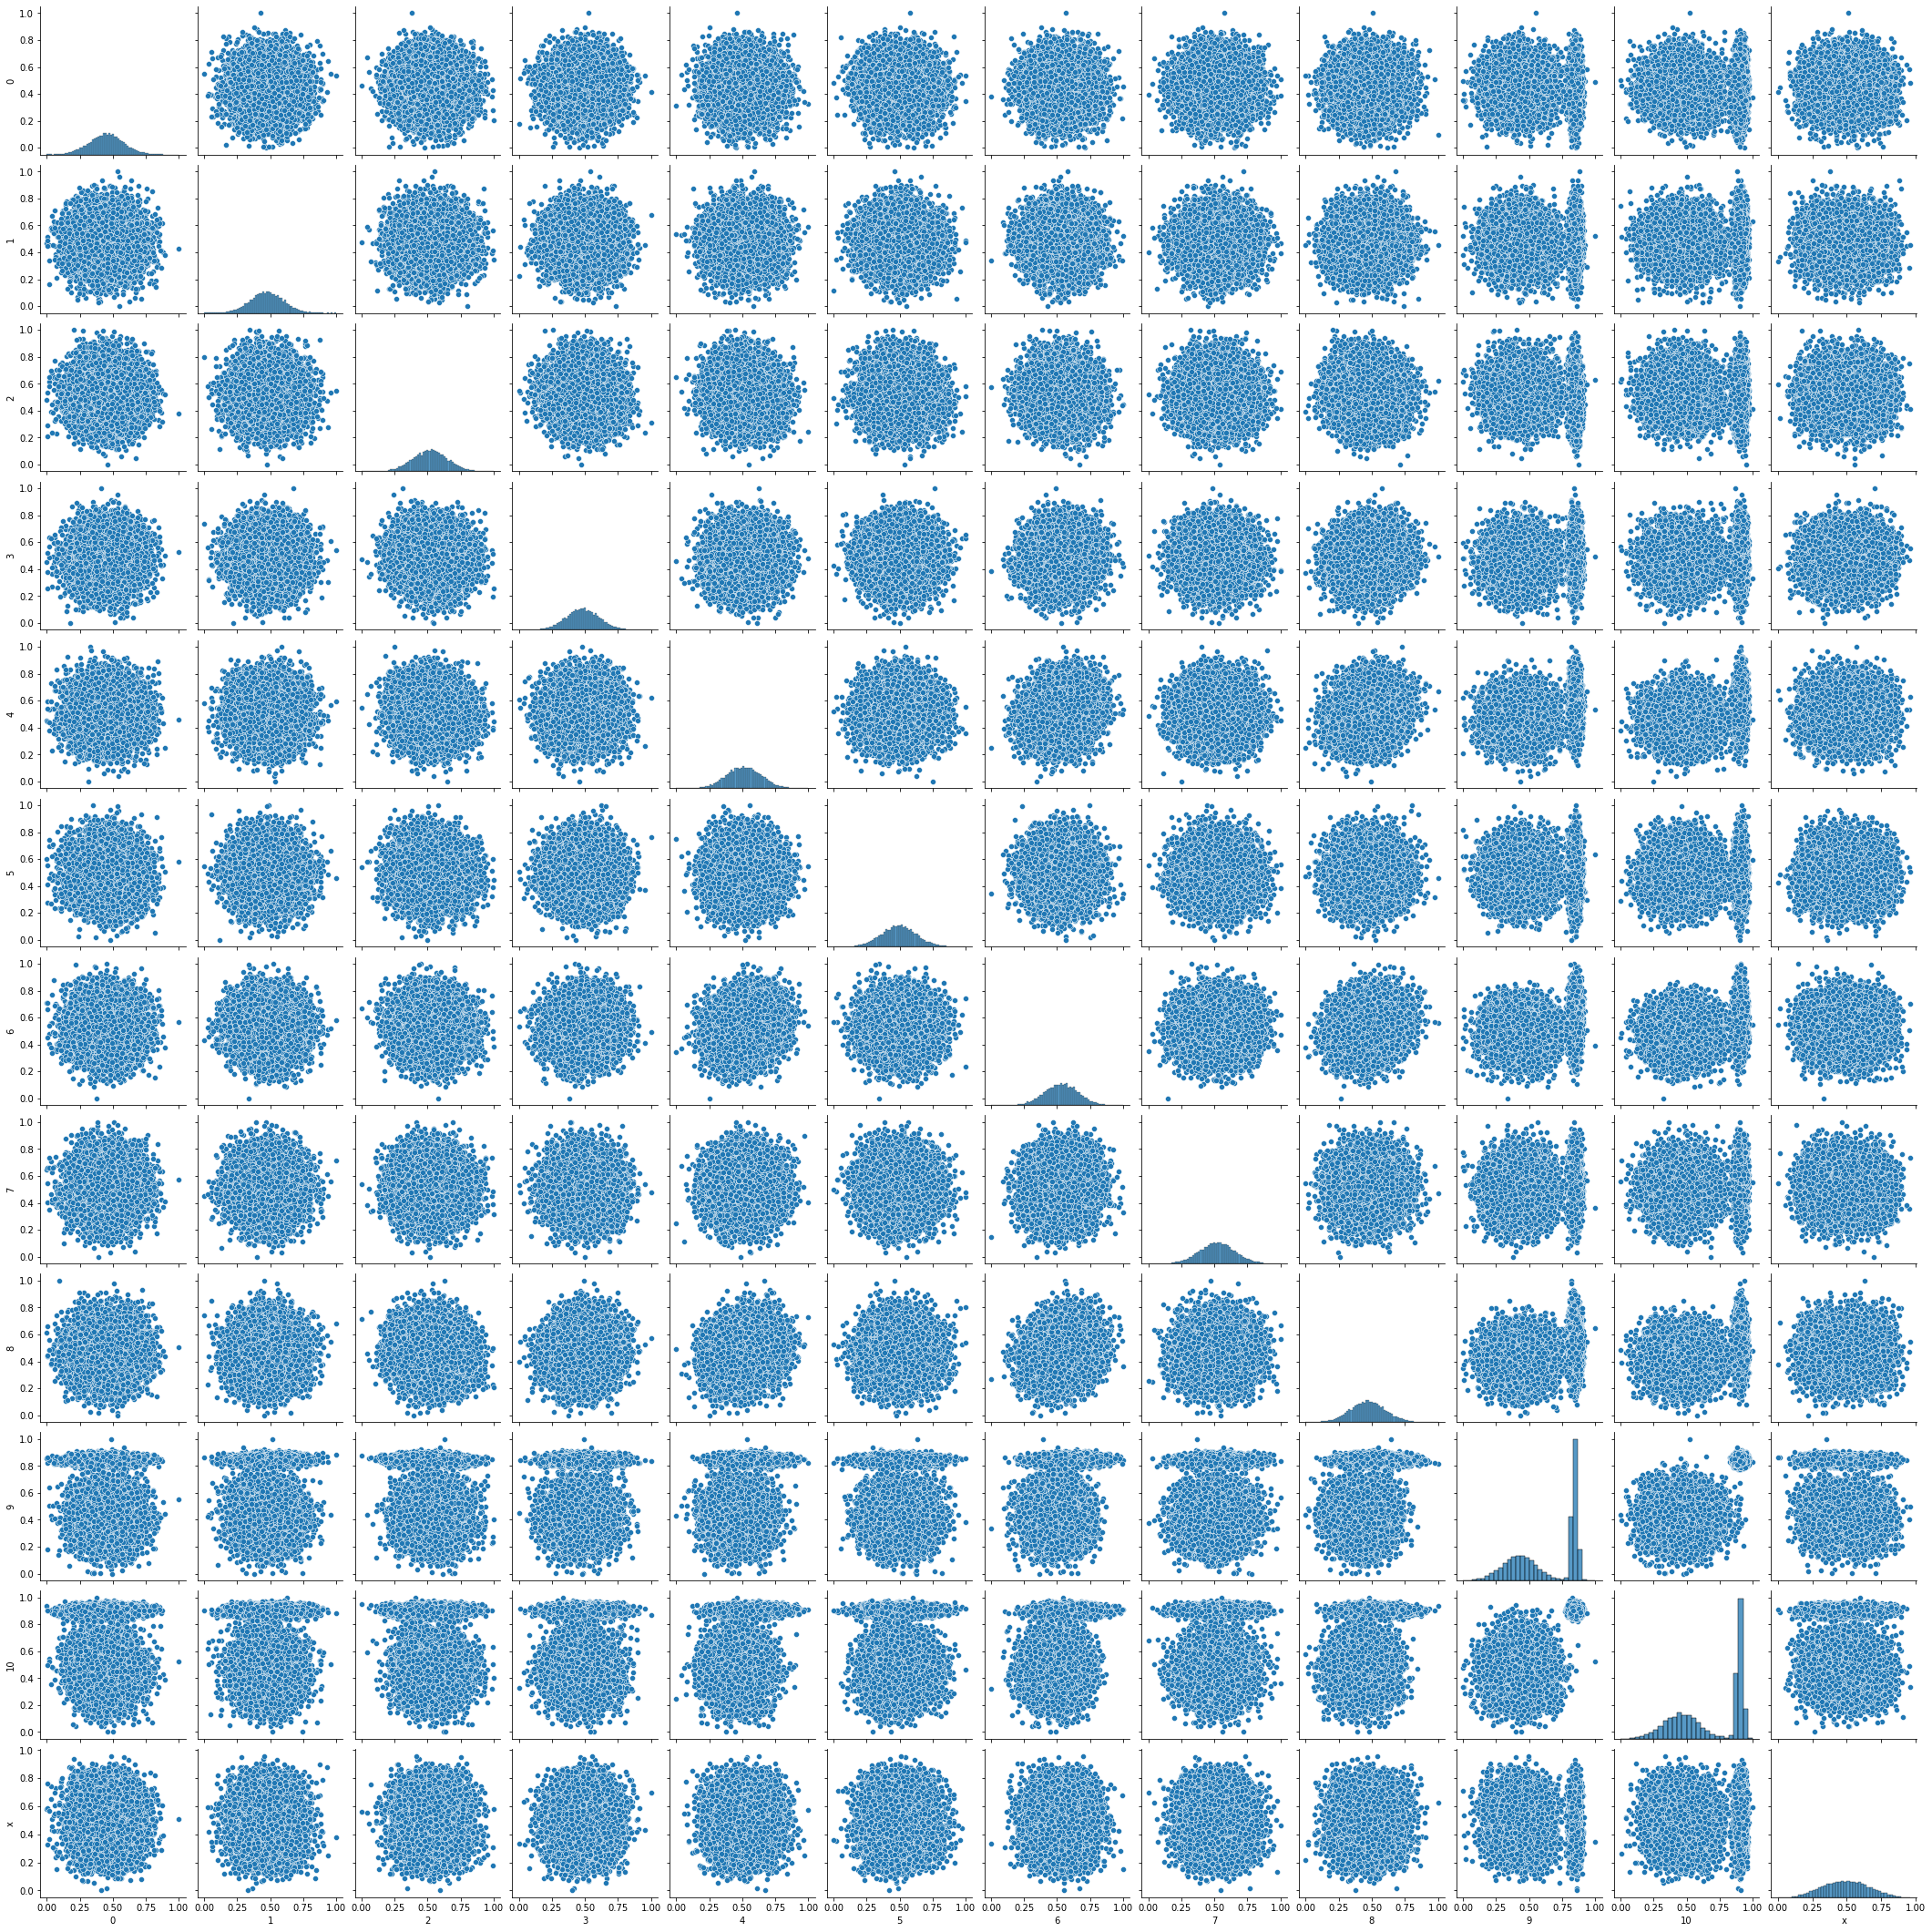

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.utils import resample

X=df.drop(columns=['x']) #input features
Y=df.iloc[:,0] #Output Feature: Pass/Fail
#Y=Encoder.fit_transform(np.array(Y).reshape(-1, 1))
#Y=Encoder.fit_transform(Y)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

#scale the input features first using min max scaler, not using normal since they are not normally distributed
scaler = MinMaxScaler()
scaler.fit(X_train)
X_scl=pd.DataFrame(scaler.fit_transform(X))

#perform variance calculation
print('max variance: ',np.max(np.max(X_scl.var())))
print('max covariance: ',np.max(np.max(X_scl.cov())))

#select features with highest variance by eliminateing those below variance threshold
thres=0.985

print('Variance Threshold: ',thres * (1 - thres))
sel = VarianceThreshold(threshold=(thres * (1 - thres)))
df_varthres=pd.DataFrame(sel.fit_transform(X_scl))
df_varthres['x']=Y

sns.pairplot(df_varthres)

Automated testing first
-----

In [ ]:
#Split into X and Y
Y=df.iloc[:,0]
X=df.drop(columns=["x"],axis=1)
X

In [ ]:
corrMatrix = X.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
#quantile transform for training set to normalize it for linear regression
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_train_trans=pd.DataFrame(X_train_trans)

#correlation matrix for Input variables
#X_train_trans.corr()

corrMatrix = X_train_trans.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
#quantile transform for testing set to normalize it for linear regression
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
X_test_trans = quantile_transformer.fit_transform(X_test)
X_test_trans=pd.DataFrame(X_test_trans)
#correlation matrix for Input variables
X_test_trans.corr()

In [ ]:
#display the normalized historgrams
fig,axs=plt.subplots(23,5,figsize=(15,50))
c=0
for i in range(0,23):
    for j in range(0,5):
        if c >= 112:
            break
        axs[i,j].set_title(str(col_names[c]))
        axs[i,j].hist(X_train_trans.iloc[:,c])
        c=c+1
        
fig.tight_layout()
plt.show()

Apply Linear Regression to untransformed data
----

In [ ]:
#perform linear regression
lin_reg=LinearRegression().fit(X_train,y_train)
y_pred=lin_reg.predict(X_test)
scores = cross_val_score(lin_reg, X_test, y_test, cv=5)

print("Test Set Score",lin_reg.score(X_test, y_test))
print("Cross Validation Score",scores)
print("Mean Absolute Error: ",metrics.mean_absolute_error(y_test,y_pred))#MAE
print("Mean Squared Error: ",metrics.mean_squared_error(y_test,y_pred))#MSE
print("Root Mean Squared Error: ",np.sqrt(metrics.mean_absolute_error(y_test,y_pred)))#RMSE


plt.scatter(y_test,y_pred)
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

In [ ]:
#polynomial kernel with degree 3
krr_poly3 = KernelRidge(alpha=150,kernel='poly',degree=3)
krr_poly3.fit(X_train,y_train)
krr_poly3.score(X_test,y_test)

y_pred=krr_poly3.predict(X_test)
y_pred2=krr_poly3.predict(X)
scores = cross_val_score(krr_poly3, X_test, y_test, cv=5)

print("Test Set Score",krr_poly3.score(X_test, y_test))
print("Cross Validation Score",scores)
print("Mean Absolute Error: ",metrics.mean_absolute_error(y_test,y_pred))#MAE
print("Mean Squared Error: ",metrics.mean_squared_error(y_test,y_pred))#MSE
print("Root Mean Squared Error: ",np.sqrt(metrics.mean_absolute_error(y_test,y_pred)))#RMSE

plt.scatter(y_test,y_pred)
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

Apply Linear Regression to X Transformed
----

In [ ]:
#perform linear regression
lin_reg=LinearRegression().fit(X_train_trans,y_train)
y_pred=lin_reg.predict(X_test_trans)
scores = cross_val_score(lin_reg, X_test_trans, y_test, cv=5)

print("Test Set Score",lin_reg.score(X_test_trans, y_test))
print("Cross Validation Score",scores)
print("Mean Absolute Error: ",metrics.mean_absolute_error(y_test,y_pred))#MAE
print("Mean Squared Error: ",metrics.mean_squared_error(y_test,y_pred))#MSE
print("Root Mean Squared Error: ",np.sqrt(metrics.mean_absolute_error(y_test,y_pred)))#RMSE

plt.scatter(y_test,y_pred)
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

Polynomial Regression on transformed data
----

In [ ]:
#polynomial kernel with degree n
krr_poly3 = KernelRidge(alpha=150,kernel='poly',degree=3)
krr_poly3.fit(X_train_trans,y_train)
krr_poly3.score(X_test_trans,y_test)

y_pred=krr_poly3.predict(X_test_trans)
scores = cross_val_score(krr_poly3, X_test_trans, y_test, cv=5)

print("Test Set Score",krr_poly3.score(X_test_trans, y_test))
print("Cross Validation Score",scores)
print("Mean Absolute Error: ",metrics.mean_absolute_error(y_test,y_pred))#MAE
print("Mean Squared Error: ",metrics.mean_squared_error(y_test,y_pred))#MSE
print("Root Mean Squared Error: ",np.sqrt(metrics.mean_absolute_error(y_test,y_pred)))#RMSE

plt.scatter(y_test,y_pred)
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

In [ ]:
#hyper parameter tuning
x_tracker=[]
score_tracker=[]
for i in range(1,5):
    krr_poly3 = KernelRidge(alpha=10^i,kernel='poly',degree=3)
    krr_poly3.fit(X_train_trans,y_train)
    x_tracker.append(i)
    score_tracker.append(krr_poly3.score(X_test_trans,y_test))

plt.plot(x_tracker,score_tracker)
plt.show()


Random Forest
-----


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [ ]:
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train, y_train)
y_pred=regr.predict(X_test)

scores = cross_val_score(regr, X_test, y_test, cv=5)

print("Test Set Score",regr.score(X_test, y_test))
print("Cross Validation Score",scores)
print("Mean Absolute Error: ",metrics.mean_absolute_error(y_test,y_pred))#MAE
print("Mean Squared Error: ",metrics.mean_squared_error(y_test,y_pred))#MSE
print("Root Mean Squared Error: ",np.sqrt(metrics.mean_absolute_error(y_test,y_pred)))#RMSE

plt.scatter(y_test,y_pred)
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

In [ ]:
regr.decision_path(X_test)

Logistic Regression
-----

In [ ]:
from sklearn.linear_model import LogisticRegression
    

Neural Network
----


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, Normalization

In [ ]:
learning_rate = 1.05
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(56, kernel_initializer='normal', activation='linear'),
    #Normalization(-1),
    Dense(32, kernel_initializer='random_normal', activation='linear'),
    #Dropout(0.5),
    Dense(1, kernel_initializer='random_normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

model.compile(
    loss=['MeanAbsoluteError','Huber'],
    optimizer='SGD', 
    metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError']
    #metrics=['RootMeanSquaredError','mean_squared_logarithmic_error']

)

# train the model
history = model.fit(
    X.values, 
    Y.values, 
    epochs=100, 
    batch_size=5000,
    validation_split=0.2
)




    #Dense(56, kernel_initializer='normal', activation='linear'),
    #Dense(8, kernel_initializer='normal', activation='linear'),
    #Dense(32, kernel_initializer='normal', activation='linear'),
    #Dropout(0.3),
    #Dense(58, kernel_initializer='normal', activation='linear'),
    #Dropout(0.2),

In [ ]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch


fig,axs=plt.subplots(2,figsize=(5,10))
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'loss'])
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_loss'])
#axs[0].xlabel('Epoch')
#axs[0].ylabel('Loss')
axs[0].legend(['loss','val_loss'])

axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'root_mean_squared_error'])
axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_root_mean_squared_error'])
#axs[1].xlabel('Epoch')
#axs[1].ylabel('Mean_squared_error')
axs[1].legend(['mean_squared_error','val_mean_squared_error'])

plt.show()

history_df

In [ ]:
y_pred=model.predict(X)

plt.scatter(Y,y_pred2,color='green')
plt.scatter(Y,y_pred,color='blue')
plt.scatter(Y,Y,color='red')
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

In [ ]:
plt.hist(Y,color='red',bins=20)
plt.hist(y_pred2,color='green',bins=20)
plt.hist(y_pred,color='blue',bins=20)
plt.legend(['Actual Output','Polynomial Regr Output','NN Output'])
plt.show()

In [ ]:
Y.shape

In [ ]:
y_pred.shape

In [ ]:
y_pred2.shape

NN using Quantile Transformed Data
----

In [ ]:
#quantile transform for testing set to normalize it for linear regression
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
X_trans = pd.DataFrame(quantile_transformer.fit_transform(X))


In [ ]:
learning_rate = 0.55
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(512, kernel_initializer='random_normal', activation='linear'),
    Dense(64, kernel_initializer='random_normal', activation='linear'),
    #Dense(4, kernel_initializer='random_normal', activation='linear'),
    Dropout(0.2),
    Dense(1, kernel_initializer='random_normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

model.compile(
    loss=['MeanAbsoluteError','Huber'],
    optimizer='SGD', 
    metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError']
    #metrics=['RootMeanSquaredError','mean_squared_logarithmic_error']

)
model.summary()

In [ ]:

# train the model
history = model.fit(
    X_trans.values, 
    Y.values, 
    epochs=100, 
    batch_size=1000,
    validation_split=0.2
)


In [ ]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch


fig,axs=plt.subplots(2,figsize=(5,10))
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'loss'])
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_loss'])
#axs[0].xlabel('Epoch')
#axs[0].ylabel('Loss')
axs[0].legend(['loss','val_loss'])

axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'root_mean_squared_error'])
axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_root_mean_squared_error'])
#axs[1].xlabel('Epoch')
#axs[1].ylabel('Mean_squared_error')
axs[1].legend(['mean_squared_error','val_mean_squared_error'])

plt.show()

history_df

In [ ]:
y_pred=model.predict(X_trans)

plt.scatter(Y,y_pred2,color='green')
plt.scatter(Y,y_pred,color='blue')
plt.scatter(Y,Y,color='red')
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

In [ ]:
plt.hist(Y,color='red',bins=30)
plt.hist(y_pred2,color='green',bins=30)
plt.hist(y_pred,color='blue',bins=30)
plt.legend(['Actual Output','Polynomial Regr Output','NN Output'])
plt.show()

Drop Bimodal Distributions
----


In [ ]:
X_dropped=df.drop(columns=["x","y10","y11"],axis=1)
X_dropped

In [ ]:
learning_rate = 1.05
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(248, kernel_initializer='normal', activation='linear'),
    #Normalization(-1),
    Dense(64, kernel_initializer='random_normal', activation='linear'),
    Dropout(0.5),
    Dense(1, kernel_initializer='random_normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

model.compile(
    loss=['MeanAbsoluteError','Huber'],
    optimizer='SGD', 
    metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError']
    #metrics=['RootMeanSquaredError','mean_squared_logarithmic_error']

)

# train the model
history = model.fit(
    X_dropped.values, 
    Y.values, 
    epochs=100, 
    batch_size=5000,
    validation_split=0.2
)


In [ ]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch


fig,axs=plt.subplots(2,figsize=(5,10))
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'loss'])
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_loss'])
#axs[0].xlabel('Epoch')
#axs[0].ylabel('Loss')
axs[0].legend(['loss','val_loss'])

axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'root_mean_squared_error'])
axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_root_mean_squared_error'])
#axs[1].xlabel('Epoch')
#axs[1].ylabel('Mean_squared_error')
axs[1].legend(['mean_squared_error','val_mean_squared_error'])

plt.show()

history_df

In [ ]:
y_pred3=model.predict(X_dropped)

plt.scatter(Y,y_pred3,color='green')
plt.scatter(Y,y_pred,color='blue')
plt.scatter(Y,Y,color='red')
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

In [ ]:
plt.hist(Y,color='red',bins=30)
#plt.hist(y_pred,color='green',bins=30)
plt.hist(y_pred3,color='green',bins=30)
plt.hist(y_pred,color='blue',bins=30)
plt.legend(['Actual Output','NN Output','Polynomial Regr Output',])
plt.show()

PCA
----

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=50)
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
pca.fit(X_train)
X_new=pca.fit_transform(X)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

In [ ]:
pca.get_covariance()

In [ ]:
pca.get_precision()

In [ ]:
X_new=pd.DataFrame(X_new)
X_new

In [ ]:
learning_rate = 1.05
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(64, kernel_initializer='normal', activation='linear'),
    #Normalization(-1),
    Dense(4, kernel_initializer='random_normal', activation='linear'),
    #Dropout(0.5),
    Dense(1, kernel_initializer='random_normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

model.compile(
    loss=['MeanAbsoluteError','Huber'],
    optimizer='SGD', 
    metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError']
    #metrics=['RootMeanSquaredError','mean_squared_logarithmic_error']

)

# train the model
history = model.fit(
    X_new.values, 
    Y.values, 
    epochs=100, 
    batch_size=5000,
    validation_split=0.2
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch


fig,axs=plt.subplots(2,figsize=(5,10))
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'loss'])
axs[0].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_loss'])
#axs[0].xlabel('Epoch')
#axs[0].ylabel('Loss')
axs[0].legend(['loss','val_loss'])

axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'root_mean_squared_error'])
axs[1].plot(history_df.loc[:,'epoch'],history_df.loc[:,'val_root_mean_squared_error'])
#axs[1].xlabel('Epoch')
#axs[1].ylabel('Mean_squared_error')
axs[1].legend(['mean_squared_error','val_mean_squared_error'])

plt.show()

history_df

In [ ]:
y_pred3=model.predict(X_new)

plt.scatter(Y,y_pred3,color='green')
plt.scatter(Y,y_pred,color='blue')
plt.scatter(Y,Y,color='red')
plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

In [ ]:
plt.hist(Y,color='red',bins=30)
#plt.hist(y_pred,color='green',bins=30)
plt.hist(y_pred3,color='green',bins=30)
plt.hist(y_pred,color='blue',bins=30)
plt.legend(['Actual Output','NN Output','Polynomial Regr Output',])
plt.show()

Encoder for X dataset
----

In [63]:
#Split into X and Y
Y=df.iloc[:,0]
X=df.drop(columns=["x"],axis=1)
X.shape

(14400, 112)

In [54]:
from scipy import stats
stats.normaltest(Y)

NormaltestResult(statistic=576.0791045207189, pvalue=8.054004787790685e-126)

In [66]:
Z=np.round(np.abs((Y-np.mean(Y))/np.std(Y)),0)
Z

20097    3.0
19869    3.0
21152    3.0
19631    3.0
17669    3.0
        ... 
4649     3.0
18049    3.0
7898     3.0
12154    3.0
19933    3.0
Name: x, Length: 14400, dtype: float64

In [127]:
from sklearn.preprocessing import OneHotEncoder
Encoder = OneHotEncoder(categories='auto')
Z_enc = Encoder.fit_transform(np.array(Z).reshape(-1, 1))
print(Z_enc.toarray())
print(Z_enc.shape)


[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
(14400, 4)


In [57]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,Z_enc,test_size=0.2,random_state=42)

In [74]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, Normalization

In [157]:
X_rs=np.resize(X,(14400,4,28))
X_rs.shape

(14400, 4, 28)

In [159]:
learning_rate = 0.05
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    #Input(input_shape=(112,)),
    #Dense(400, kernel_initializer='normal', activation='relu'),
    Conv1D(filters=64, kernel_size=7, activation='relu'),
    Normalization(-1),
    Dense(64, kernel_initializer='random_normal', activation='softmax'),
    Dropout(0.5),
    Dense(4, kernel_initializer='random_normal', activation='sigmoid')
  ])
  return model
# build the model
model = build_model_using_sequential()

model.compile(
    loss=['categorical_crossentropy'],
    optimizer='SGD', 
    metrics=['categorical_crossentropy','accuracy']
    #metrics=['RootMeanSquaredError','mean_squared_logarithmic_error']

)

# train the model
history = model.fit(
    X_rs, 
    Z_enc.toarray(), 
    epochs=3, 
    batch_size=1000,
    validation_split=0.2
)


Z_enc_pred=model.predict(X_rs)
Z_pred=Encoder.inverse_transform(Z_enc_pred)
plt.hist(Z,color='green')
plt.hist(Z_pred,color='blue')
#plt.scatter(Y,Y,color='red')
#plt.plot(np.linspace(0,1.0,num=10),np.linspace(0,1.0,num=10),color='r')
plt.show()

Epoch 1/3


ValueError: in user code:

    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\engine\sequential.py:383 call
        outputs = layer(inputs, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\keras\layers\convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\nn_ops.py:1131 convolution_v2
        return convolution_internal(
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\nn_ops.py:1261 convolution_internal
        return op(
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\util\deprecation.py:617 new_func
        return func(*args, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\util\deprecation.py:617 new_func
        return func(*args, **kwargs)
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\nn_ops.py:2003 conv1d
        result = gen_nn_ops.conv2d(
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:968 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 7 from 4 for '{{node sequential_34/conv1d_12/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_34/conv1d_12/conv1d/ExpandDims, sequential_34/conv1d_12/conv1d/ExpandDims_1)' with input shapes: [?,1,4,28], [1,7,28,64].
